In [10]:
import scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import correlate, correlation_lags
import scipy
import mne
from nilearn import datasets, image, plotting
import scipy.io
import re
import seaborn
import pickle
import sklearn
from sklearn.mixture import GaussianMixture

# Computing Cross Correlations w/ Shuffled Audio Signal

In [11]:
id_eleccount = # Removed to protect patient anonymity

### Concatenating + Saving CC for Each Patient

In [ ]:
def arrange_cc_by_elec(patient_id):
    cc_by_channel = np.zeros((1000, 70*512 + 1))
    
    for j in range(0, id_eleccount[patient_id]):
        for i in range(0, 1000):
            cc_by_channel[i, :] = np.load("/scratch/gpfs/mayaar/GravityECoG/code/AudioAnalysis/corr1-" + patient_id + "-" + str(i) + ".npy", allow_pickle = True)[j, :]
        np.save("/scratch/gpfs/mayaar/GravityECoG/code/AudioAnalysis/CCByChannel/ny" + patient_id + "/cc1-nr-" + patient_id + "-" + str(j) + ".npy", cc_by_channel)
        
    for j in range(0, id_eleccount[patient_id]):
        for i in range(0, 1000):
            cc_by_channel[i, :] = np.load("/scratch/gpfs/mayaar/GravityECoG/code/AudioAnalysis/corr2-" + patient_id + "-" + str(i) + ".npy", allow_pickle = True)[j, :]
        np.save("/scratch/gpfs/mayaar/GravityECoG/code/AudioAnalysis/CCByChannel/ny" + patient_id + "/cc2-nr-" + patient_id + "-" + str(j) + ".npy", cc_by_channel)

In [ ]:
for key in id_eleccount.keys():
    arrange_cc_by_elec(key)

### Z-Scoring Correlations

In [ ]:
g1 = np.load("../../sourcedata/grav1preprocessedaudio.npy", allow_pickle = True)
g2 = np.load("../../sourcedata/grav2preprocessedaudio.npy", allow_pickle = True)

In [ ]:
def cross_correlate(film_data, neural_data):
    xcorr_arr = np.zeros((neural_data.shape[0], film_data.shape[0] + neural_data.shape[1] - 1))
    lags_arr = np.zeros((neural_data.shape[0], film_data.shape[0] + neural_data.shape[1] - 1))
    for i in range(neural_data.shape[0]):
        xcorr_arr[i,:] = correlate(film_data - np.mean(film_data), neural_data[i, :] - np.mean(neural_data[i, :]), mode='full')
        lags_arr[i,:] = correlation_lags(film_data.shape[0], neural_data.shape[1], mode="full")
    return xcorr_arr, lags_arr

In [ ]:
# Compute Z-Score for +/- 35 seconds lag around the start of the movie
def z_score_cc(cc, film_data, neural_data, electrode_num, proper_cc, spearman_lags, zero_lag_idx):
    # At every electrode and every time point, compute mean and stddev (of shuffled cc)
    shuffled_means = np.mean(cc, axis=0)
    shuffled_stdevs = np.std(cc, axis=0)
    # Z-Scored Correlations
    z_scored_cc = (proper_cc[electrode_num, :] - shuffled_means) / shuffled_stdevs
    lags_center_arr = spearman_lags[electrode_num, zero_lag_idx - 35*512:zero_lag_idx + 35*512 + 1]
    
    return z_scored_cc[:, zero_lag_idx - 35*512:zero_lag_idx + 35*512 + 1], lags_center_arr

In [ ]:
def z_score_full(patient_id):
    nr_1 = np.load("../../sourcedata/non-ranked-ecog/nr-ecog1-" + patient_id + ".npy", allow_pickle = True)
    nr_2 = np.load("../../sourcedata/non-ranked-ecog/nr-ecog2-" + patient_id + ".npy", allow_pickle = True)

    # Proper Correlations (G1)
    spearman_cc, spearman_lags = cross_correlate(g1, nr_1)
    zero_lag_idx = np.where(spearman_lags[0, :] == 0)[0][0]
    proper_cc_1 = spearman_cc[:, zero_lag_idx - 35*512:zero_lag_idx + 35*512 + 1]
    
    # Compute Z-Score for each electrode
    for i in range(id_eleccount[patient_id]):
        cc_surrog = np.load("CCByChannel/ny" + patient_id + "/cc1-nr-" + patient_id + "-" + str(i) + ".npy", allow_pickle = True)
        zscc_1, lags_1 = z_score_cc(cc_surrog, g1, nr_1, i, proper_cc_1, spearman_lags, zero_lag_idx)
        np.save("ZScoredCC/ny" + patient_id + "/zscc1-" + patient_id + "-" + str(i) + ".npy", zscc_1)
    
    zc_by_elec = np.zeros(proper_cc_1.shape)
    for i in range(id_eleccount[patient_id]):
        zc_by_elec[i, :] = np.load("ZScoredCC/ny" + patient_id + "/zscc1-" + patient_id + "-" + str(i) + ".npy", allow_pickle = True)
    np.save("av_across_elec_1_" + patient_id + ".npy", np.mean(zc_by_elec, axis=0)) 
    np.save("zc_by_elec_1_" + patient_id + ".npy", zc_by_elec)  
    
    # Proper Correlations (G2)
    spearman_cc, spearman_lags = cross_correlate(g2, nr_2)
    zero_lag_idx = np.where(spearman_lags[0, :] == 0)[0][0]
    proper_cc_2 = spearman_cc[:, zero_lag_idx - 35*512:zero_lag_idx + 35*512 + 1]
    
    # Compute Z-Score for each electrode
    for i in range(id_eleccount[patient_id]):
        cc_surrog = np.load("CCByChannel/ny" + patient_id + "/cc2-nr-" + patient_id + "-" + str(i) + ".npy", allow_pickle = True)
        zscc_2, lags_2 = z_score_cc(cc_surrog, g1, nr_2, i, proper_cc_2, spearman_lags, zero_lag_idx)
        np.save("ZScoredCC/ny" + patient_id + "/zscc2-" + patient_id + "-" + str(i) + ".npy", zscc_2)
        
    zc_by_elec = np.zeros(proper_cc_2.shape)
    for i in range(id_eleccount[patient_id]):
        zc_by_elec[i, :] = np.load("ZScoredCC/ny" + patient_id + "/zscc2-" + patient_id + "-" + str(i) + ".npy", allow_pickle = True)
    np.save("av_across_elec_2_" + patient_id + ".npy", np.mean(zc_by_elec, axis=0))    
    np.save("zc_by_elec_2_" + patient_id + ".npy", zc_by_elec)  

In [ ]:
for key in id_eleccount.keys():
    z_score_full(key)

# T-Test

In [12]:
lags = np.load("../../derivatives/results/audio-envelope/audio_lags.npy", allow_pickle=True)

In [ ]:
# Partially removed to protect patient anonymity

In [ ]:
# Extract zero-lag index
np.where(lags == 0)

(array([15872]),)

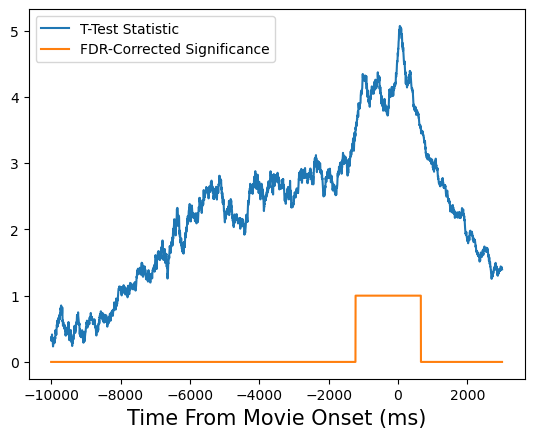

In [25]:
# Flip plot lag axis for clarity
plt.plot(lag_ms*-1, t_vals[15872 - 3*512:15872 + 10*512 + 1], label='T-Test Statistic')
plt.plot(lag_ms*-1, fdr_vals, label='FDR-Corrected Significance')
plt.xlabel('Time From Movie Onset (ms)', fontsize=15)
plt.legend(loc='upper left')
ax = plt.gca()

plt.savefig("audio_fdr.png", dpi=600)

In [26]:
# Brain Delay: 54.6875 ms
print(lags[12000 + np.argmax(t_vals[12000:18000])] * (-1000/512))

54.6875


In [27]:
# Window of Significance: 15534 to 16498
print(np.where(fdr_p[0])[0][0] + 12000) 
print(np.where(fdr_p[0])[0][-1] + 12000)

15534
16498


In [28]:
peak_idx = 12000 + np.argmax(t_vals[12000:18000])

In [27]:
zc_at_peak = []
zc_labels = []

for key in id_eleccount.keys():
    zc_1 = np.load("../../derivatives/results/audio-envelope/zc_by_elec_1_" + key + ".npy", allow_pickle = True)
    zc_2 = np.load("../../derivatives/results/audio-envelope/zc_by_elec_2_" + key + ".npy", allow_pickle = True)
    zc_at_peak.extend(np.mean(np.array([zc_1[:, peak_idx], zc_2[:, peak_idx]]), axis=0))
    for i in range(id_eleccount[key]):
        zc_labels.append(str(key) + "_" + str(i))

In [28]:
# Fit a two-component Gaussian Mixture Models (one that's zero-centered; separate signal from noise)
gmm = GaussianMixture(n_components = 2).fit(np.array(zc_at_peak).reshape(-1, 1))

In [29]:
# Select electrodes based on Z-score such that they are 10 times as
# likely to be from signal as opposed to the noise distribution
pp = gmm.predict_proba(np.array(zc_at_peak).reshape(-1, 1))

signif_electrode_list = []

for i in range(pp.shape[0]):
    if (pp[i][1] > pp[i][0] * 10):
        signif_electrode_list.append(zc_labels[i])

In [30]:
signif_electrode_list.sort()

In [31]:
len(signif_electrode_list)

100

In [ ]:
np.save("../../derivatives/results/audio-envelope/signif_audio_elec.npy", signif_electrode_list)

In [ ]:
signif_electrode_dict = # Removed to protect patient anonymity:[]}

for i in signif_electrode_list:
    split = re.split('_', i)
    signif_electrode_dict[split[0]].append(int(split[1]))

In [ ]:
# create a binary pickle file 
f = open("../../derivatives/results/audio-envelope/signif_electrode_dict.pkl","wb")

# write the python object (dict) to pickle file
pickle.dump(signif_electrode_dict,f)

# close file
f.close()

### Deprecated: Alternative Method of Selecting Significant Electrodes (Z-Score > 95th percentile)

In [ ]:
def get_sig_elec(patient_id):    
    signif_electrode_list_1 = []
    signif_electrode_list_2 = []

    for i in range(id_eleccount[patient_id]):
        zc =  np.load("../../derivatives/results/audio-envelope/ZScoredCC/ny" + patient_id + "/zscc1-" + patient_id + "-" + str(i) + ".npy", allow_pickle = True)
        zc = zc[15534:16498]
        if (zc[zc > 1.645].shape[0]):
            signif_electrode_list_1.append(str(patient_id) + "_" + str(i)) 

        zc = np.load("../../derivatives/results/audio-envelope/ZScoredCC/ny" + patient_id + "/zscc2-" + patient_id + "-" + str(i) + ".npy", allow_pickle = True)
        zc = zc[15534:16498]
        if (zc[zc > 1.645].shape[0]):
            signif_electrode_list_2.append(str(patient_id) + "_" + str(i))

    signif_electrode_list.extend(set(signif_electrode_list_1).intersection(set(signif_electrode_list_2)))
    

In [ ]:
signif_electrode_list = []
for key in id_eleccount.keys():
    get_sig_elec(key)

# Plotting Significant Correlations

In [2]:
signif_electrode_dict = pickle.load(open("../../derivatives/results/audio-envelope/signif_elec_dict.pkl", "rb"))

In [4]:
signif_electrode_list = np.load("../../derivatives/results/audio-envelope/signif_audio_elec.npy", allow_pickle=True)

In [3]:
# Retrieve the AAL atlas
aal_atlas = datasets.fetch_atlas_aal('SPM12')

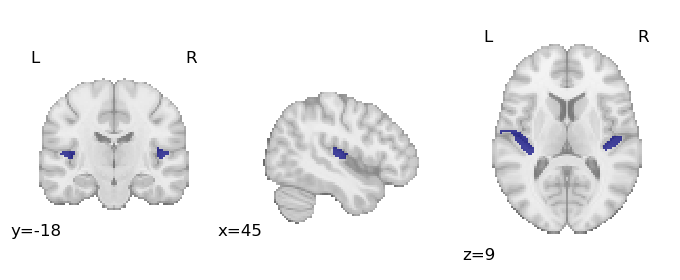

In [41]:
# ROI: STG (Heschel’s Gyrus, Brodmann's Area 22, etc.)

# Find the index of the target regions in the AAL atlas map
tsl_idx = aal_atlas.indices[aal_atlas.labels.index('Temporal_Sup_L')]
tsr_idx = aal_atlas.indices[aal_atlas.labels.index('Temporal_Sup_R')]
hl_idx = aal_atlas.indices[aal_atlas.labels.index('Heschl_L')]
hr_idx = aal_atlas.indices[aal_atlas.labels.index('Heschl_R')]

# Select only voxels for which the value is equal to this index
tsl_map = image.math_img('img == %s' % tsl_idx, img=aal_atlas.maps)
tsr_map = image.math_img('img == %s' % tsr_idx, img=aal_atlas.maps)
hl_map = image.math_img('img == %s' % hl_idx, img=aal_atlas.maps)
hr_map = image.math_img('img == %s' % hr_idx, img=aal_atlas.maps)

# mask = image.math_img('img1 + img2 + img3 + img4', img1=tsl_map, img2=tsr_map, img3=hl_map, img4=hr_map)

mask = image.math_img('img3 + img4', img3=hl_map, img4=hr_map)

fig = plotting.plot_roi(mask, draw_cross=False)
plt.savefig("audio_roi.png", dpi=600)

In [5]:
def plot_max_corr_on_brain():
    filtered_data = []
    filtered_elecpos = []
    
    for key in signif_electrode_dict:
        elecpos = scipy.io.loadmat('/scratch/gpfs/mayaar/GravityECoG/derivatives/preprocessing/sub-ny' + key + '/eeg1_manualica_notch_elec_elecpos.mat')['trial']
        stat_signif_elec = signif_electrode_dict[key]
        
        for i in signif_electrode_dict[key]:
            zc_1 = np.load("../../derivatives/results/audio-envelope/ZScoredCC/ny" + key + "/zscc1-" + key + "-" + str(i) + ".npy", allow_pickle = True)[15534:16498]
            zc_2 = np.load("../../derivatives/results/audio-envelope/ZScoredCC/ny" + key + "/zscc2-" + key + "-" + str(i) + ".npy", allow_pickle = True)[15534:16498]
            filtered_data.append(np.amax(np.mean(np.array([zc_1, zc_2]), axis=0)))

        filtered_elecpos.append(elecpos[stat_signif_elec, :])

    # Flatten Data
    filtered_elecpos = [item for sublist in filtered_elecpos for item in sublist]

    # Plot correlations for statistically significant electrodes
    fig = plt.figure(figsize=(12, 6))
    plotting.plot_markers(filtered_data,
                    filtered_elecpos,
                    node_size=10,
                    node_vmin=-np.max(filtered_data),
                    node_vmax=np.max(filtered_data),
                    node_cmap=plt.cm.jet,
                    node_threshold=None,
                    display_mode='lzry',
                    figure=fig,
                    axes=None,
                    title=None,
                    annotate=True,
                    colorbar=True)

    return fig

In [6]:
def plot_av_corr_on_brain():
    filtered_data = []
    filtered_elecpos = []
    
    for key in signif_electrode_dict:
        elecpos = scipy.io.loadmat('/scratch/gpfs/mayaar/GravityECoG/derivatives/preprocessing/sub-ny' + key + '/eeg1_manualica_notch_elec_elecpos.mat')['trial']
        stat_signif_elec = signif_electrode_dict[key]
        
        for i in signif_electrode_dict[key]:
            zc_1 = np.load("../../derivatives/results/audio-envelope/ZScoredCC/ny" + key + "/zscc1-" + key + "-" + str(i) + ".npy", allow_pickle = True)[15534:16498]
            zc_2 = np.load("../../derivatives/results/audio-envelope/ZScoredCC/ny" + key + "/zscc2-" + key + "-" + str(i) + ".npy", allow_pickle = True)[15534:16498]
            filtered_data.append(np.mean(np.mean(np.array([zc_1, zc_2]), axis=0)))

        filtered_elecpos.append(elecpos[stat_signif_elec, :])

    # Flatten Data
    filtered_elecpos = [item for sublist in filtered_elecpos for item in sublist]

    # Plot correlations for statistically significant electrodes
    fig = plt.figure(figsize=(12, 6))
    plotting.plot_markers(filtered_data,
                    filtered_elecpos,
                    node_size=10,
                    node_vmin=-np.max(filtered_data),
                    node_vmax=np.max(filtered_data),
                    node_cmap=plt.cm.jet,
                    node_threshold=None,
                    display_mode='lzry',
                    figure=fig,
                    axes=None,
                    title=None,
                    annotate=True,
                    colorbar=True)

    return fig

In [7]:
def plot_lag_map_brain():
    filtered_data = []
    filtered_elecpos = []
    
    for key in signif_electrode_dict:
        elecpos = scipy.io.loadmat('/scratch/gpfs/mayaar/GravityECoG/derivatives/preprocessing/sub-ny' + key + '/eeg1_manualica_notch_elec_elecpos.mat')['trial']
        stat_signif_elec = signif_electrode_dict[key]
        
        for i in signif_electrode_dict[key]:
            zc_1 = np.load("../../derivatives/results/audio-envelope/ZScoredCC/ny" + key + "/zscc1-" + key + "-" + str(i) + ".npy", allow_pickle = True)[15534:16498]
            zc_2 = np.load("../../derivatives/results/audio-envelope/ZScoredCC/ny" + key + "/zscc2-" + key + "-" + str(i) + ".npy", allow_pickle = True)[15534:16498]
            
            lags = np.load("../../derivatives/results/audio-envelope/audio_lags.npy", allow_pickle=True)
            lags = lags[15534:16498]
            l = lags[np.argmax(np.mean(np.array([zc_1, zc_2]), axis=0))] * (1000/512)
            if l < 300 and l > -300:
                filtered_data.append(l * -1) # lag in seconds
                filtered_elecpos.append(elecpos[i, :])

    # Plot correlations for statistically significant electrodes
    fig = plt.figure(figsize=(12, 6))
    plotting.plot_markers(filtered_data,
                    filtered_elecpos,
                    node_size=10,
                    node_vmin=0, # np.max(filtered_data)
                    node_vmax=200,
                    node_cmap=plt.cm.jet,
                    node_threshold=None,
                    display_mode='lzry',
                    figure=fig,
                    axes=None,
                    title=None,
                    annotate=True,
                    colorbar=True)

    return fig

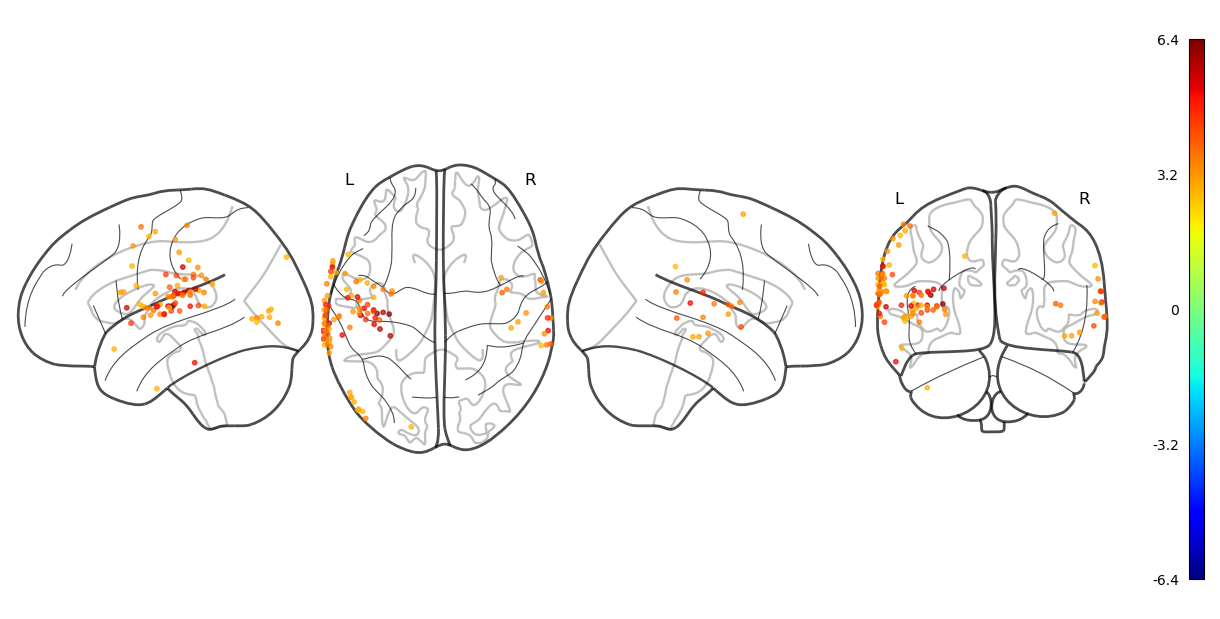

In [11]:
fig = plot_max_corr_on_brain()
plt.savefig("peak_zc.png", dpi=600)

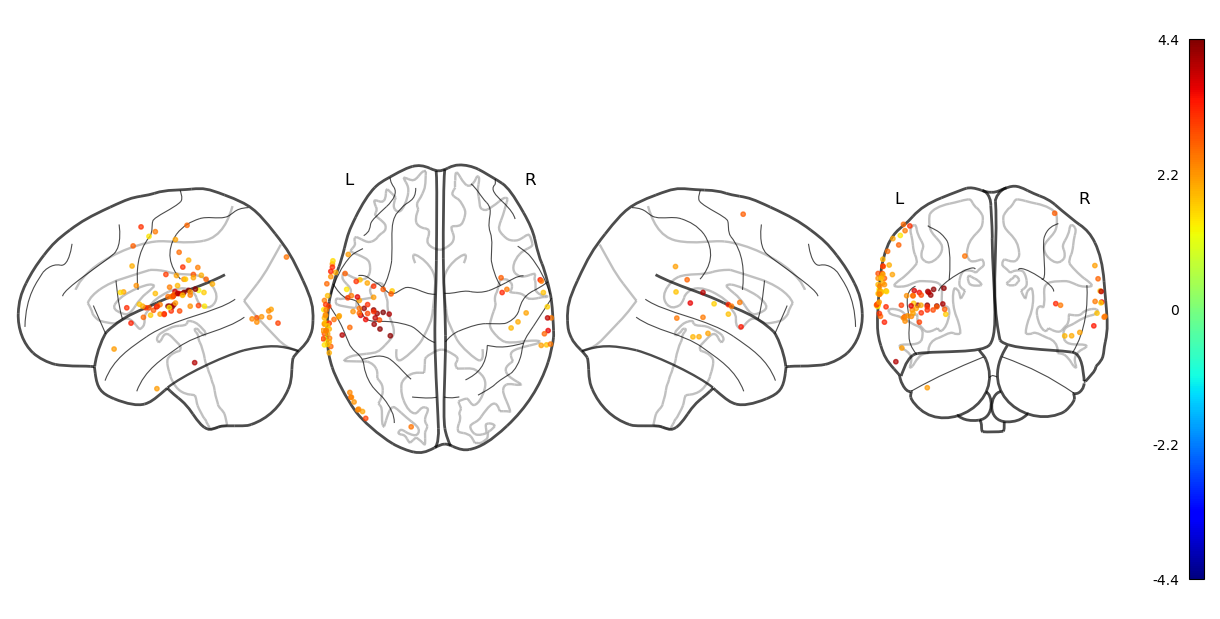

In [12]:
fig = plot_av_corr_on_brain()

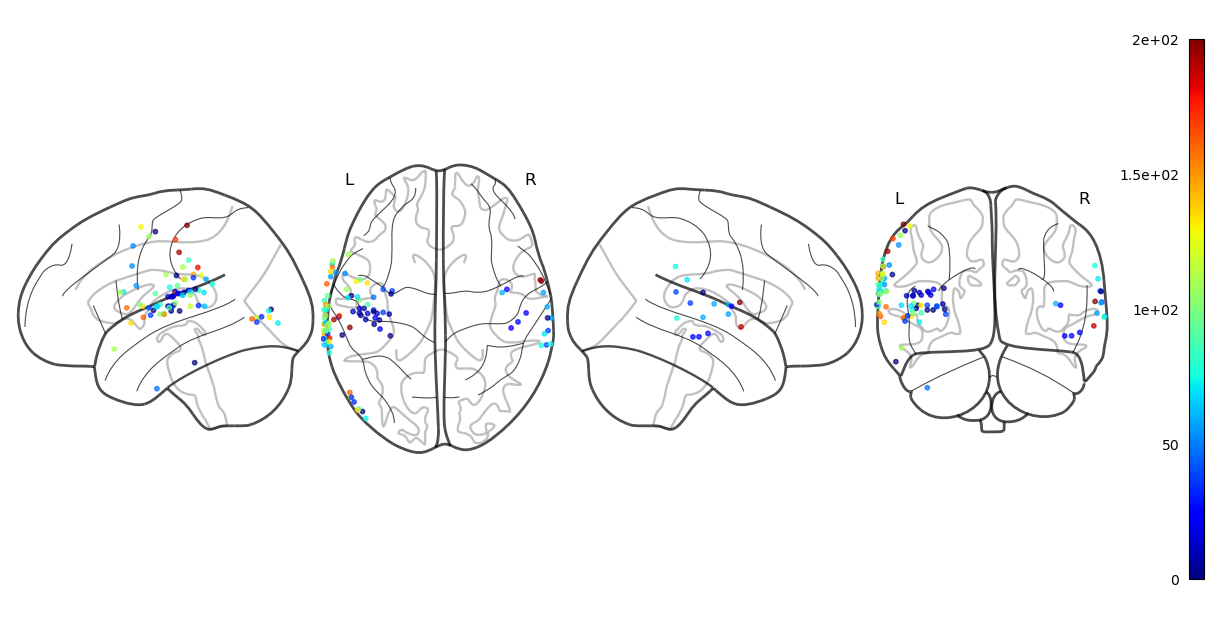

In [13]:
fig = plot_lag_map_brain()
plt.savefig("zc_lag.png", dpi=600)

# Violin Plot

In [32]:
peak_idx = 12000 + np.argmax(t_vals[12000:18000])

In [33]:
peak_idx

15844

In [34]:
zc_at_peak = []
for key in id_eleccount.keys():
    zc_1 = np.load("../../derivatives/results/audio-envelope/zc_by_elec_1_" + key + ".npy", allow_pickle = True)
    zc_2 = np.load("../../derivatives/results/audio-envelope/zc_by_elec_2_" + key + ".npy", allow_pickle = True)
    zc_at_peak.extend(np.mean(np.array([zc_1[:, peak_idx], zc_2[:, peak_idx]]), axis=0))
    
# print(zc_at_peak)

In [35]:
len(zc_at_peak)

1240

In [36]:
# Fit 2 Gaussian Mixture Models (one that's zero-centered; separate signal from noise)
gmm = GaussianMixture(n_components = 2).fit(np.array(zc_at_peak).reshape(-1, 1))

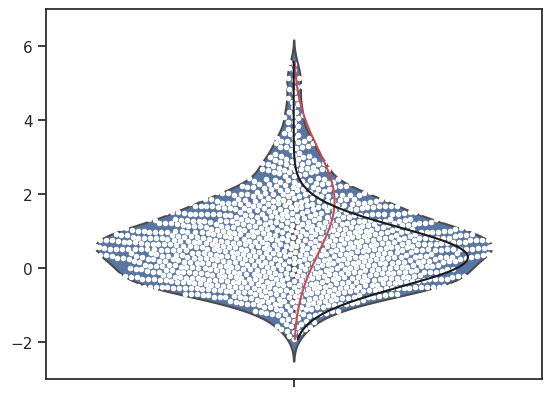

In [80]:
f_axis = np.array(zc_at_peak).copy().ravel()
f_axis.sort()
a = []
for weight, mean, covar in zip(gmm.weights_, gmm.means_, gmm.covariances_):
    a.append(weight*scipy.stats.norm.pdf(f_axis, mean, np.sqrt(covar)).ravel())
plt.plot(a[0], f_axis, '-r', zorder=4)
plt.plot(a[1], f_axis, '-k', zorder=4)
# plt.tight_layout()
plt.ylim(-3, 7)

# use to set style of background of plot
seaborn.set(style="white")
seaborn.set_style("ticks")
violin_plot = seaborn.violinplot(y=zc_at_peak)
# violin_plot.set(ylabel="Z-Score", title="Z-Score per Electrode at Time of Peak Average Z-Score (All Patients)")
seaborn.swarmplot(y=zc_at_peak, color= "white", size=4, zorder=3)
# plt.grid(color='grey')
fig = violin_plot.get_figure()
plt.savefig("violin.png", dpi=600)

# Average Z-Score Across All Patients and Electrodes

In [39]:
# Partially removed to protect patient anonymity

In [40]:
av_all_elec = np.mean(full_elec_av, axis=0)

In [41]:
av_all_elec.shape

(35841,)

In [42]:
np.where(lags == 0) # 15534:16498

(array([15872]),)

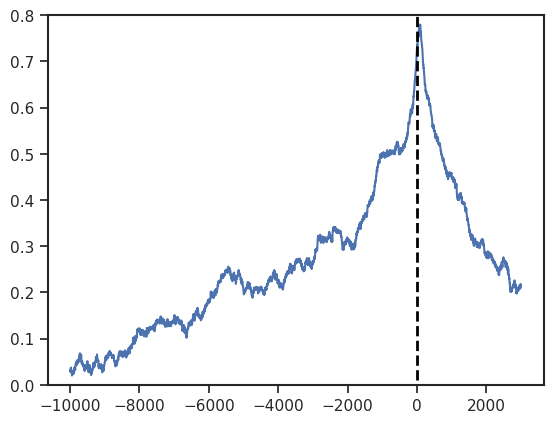

In [101]:
import matplotlib as mpl
mpl.rcParams['axes.linewidth'] = 1.5

fig, ax = plt.subplots()
ax.plot(lags[15872-3*512:15872+10*512]*-1*1000/512, av_all_elec[15872-3*512:15872+10*512])
ax.patch.set_edgecolor('black') 
ax.vlines(x=0.0, ymin=0.01, ymax=0.85, linewidth=2, color='black', linestyle='dashed')
# plt.title("Average ECoG-Audio Z-Score Across All Patients/Electrodes")
# plt.ylabel("Z-Score")
# plt.xlabel("Lag From Movie Onset (ms)")
plt.ylim([0, 0.8])
plt.savefig("av_across_elec.png", bbox_inches='tight', dpi=600)

In [ ]:
filtered_data = np.zeros((len(signif_electrode_list), 35841))

j = 0
for key in signif_electrode_dict:
    for i in signif_electrode_dict[key]:
        zc_1 = np.load("../../derivatives/results/audio-envelope/ZScoredCC/ny" + key + "/zscc1-" + key + "-" + str(i) + ".npy", allow_pickle = True)
        zc_2 = np.load("../../derivatives/results/audio-envelope/ZScoredCC/ny" + key + "/zscc2-" + key + "-" + str(i) + ".npy", allow_pickle = True)
        
        filtered_data[j, :] = np.mean(np.array([zc_1, zc_2]), axis=0)
        j = j + 1

In [ ]:
av_all_elec = np.mean(filtered_data, axis=0)

In [ ]:
plt.plot(lags[15872-2*512:15872+2*512]*-1*1000/512, av_all_elec[15872-2*512:15872+2*512])
# plt.axhline(y = 1.645, color = 'r', linestyle = '-')
plt.title("Average ECoG-Audio Z-Score Across All Statistically Significant Electrodes")
plt.ylabel("Z-Score")
plt.xlabel("Lag From Movie Onset (ms)")
# plt.savefig("av_across_elec.png", bbox_inches='tight', dpi=600)

# Plotting Significant Electrodes

In [29]:
signif_elec_matrix = np.zeros((99, 4*512))

j = 0
for key in signif_electrode_dict:
    stat_signif_elec = signif_electrode_dict[key]
        
    for i in signif_electrode_dict[key]:
        zc_1 = np.load("../../derivatives/results/audio-envelope/ZScoredCC/ny" + key + "/zscc1-" + key + "-" + str(i) + ".npy", allow_pickle = True)
        zc_2 = np.load("../../derivatives/results/audio-envelope/ZScoredCC/ny" + key + "/zscc2-" + key + "-" + str(i) + ".npy", allow_pickle = True)
        signif_elec_matrix[j, :] = np.mean(np.array([zc_1, zc_2]), axis=0)[15872-2*512:15872+2*512]
        
        j = j + 1

In [30]:
# Baseline Correction
bc = (np.mean(signif_elec_matrix[:,0:512]) + np.mean(signif_elec_matrix[:,-512:])) / 2
signif_elec_matrix -= bc

In [31]:
a = np.zeros(signif_elec_matrix.shape[0])
for i in range(signif_elec_matrix.shape[0]):
    a[i] = np.argmax(signif_elec_matrix[i, :])
    
idxs = np.argsort(a)[::-1].argsort()

# Sorting matrix by lag of peak
sorted_matrix = np.zeros(signif_elec_matrix.shape)
for i in range(signif_elec_matrix.shape[0]):
    sorted_matrix[idxs[i]] = signif_elec_matrix[i, :]

In [32]:
xaxis =  np.arange(-1000, 1001, 1, dtype=int) * 2
depth_list = xaxis.tolist()

num_ticks = 20
# the index of the position of yticks
xticks = np.linspace(0, len(depth_list) - 1, num_ticks, dtype=int)
# the content of labels of these yticks
xticklabels = [depth_list[idx] for idx in xticks]

[Text(69.58333333333333, 0.5, 'Electrodes'),
 Text(0.5, 23.52222222222222, 'Time Around Movie Start (ms)')]

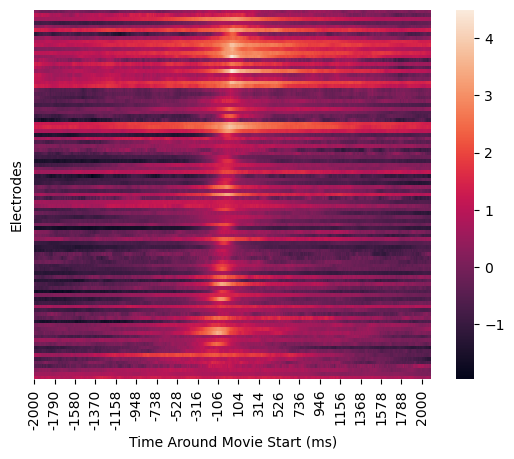

In [33]:
heatmap = seaborn.heatmap(sorted_matrix, xticklabels=xticklabels, yticklabels=False)
heatmap.set_xticks(xticks)
heatmap.set_xticklabels(xticklabels)
heatmap.set(ylabel="Electrodes", xlabel="Time Around Movie Start (ms)")

# Distance from Heschel's Gyrus

In [3]:
# Heschel's Gyrus (Left+ Rights Hemispheres) in MNI space
hg_l = np.array([-42, -19, 10])
hg_r = np.array([46, -17, 10])

In [4]:
hg_dist = []
peak_zc = []

for key in signif_electrode_dict:
    elecpos = scipy.io.loadmat('/scratch/gpfs/mayaar/GravityECoG/derivatives/preprocessing/sub-ny' + key + '/eeg1_manualica_notch_elec_elecpos.mat')['trial']
    stat_signif_elec = signif_electrode_dict[key]
    filtered_elecpos = elecpos[stat_signif_elec, :]
    
    for i in range(len(stat_signif_elec)):
        left_dist = np.linalg.norm(hg_l - filtered_elecpos[i, :])
        right_dist = np.linalg.norm(hg_r - filtered_elecpos[i, :])
        if left_dist < right_dist:
            hg_dist.append(left_dist)
        else:
            hg_dist.append(right_dist)
            
    for i in signif_electrode_dict[key]:  
        zc_1 = np.load("../../derivatives/results/audio-envelope/ZScoredCC/ny" + key + "/zscc1-" + key + "-" + str(i) + ".npy", allow_pickle = True)[15534:16498]
        zc_2 = np.load("../../derivatives/results/audio-envelope/ZScoredCC/ny" + key + "/zscc2-" + key + "-" + str(i) + ".npy", allow_pickle = True)[15534:16498]
        peak_zc.append(np.amax(np.mean(np.array([zc_1, zc_2]), axis=0)))
            
            
hg_dist = np.array(hg_dist)
peak_zc = np.array(peak_zc)
# print(np.correlate(hg_dist, peak_zc))    

In [5]:
np.mean(hg_dist)

30.97121691263138

In [6]:
np.mean(hg_dist[np.argsort(peak_zc)[::-1][:10]])

15.92650291760834

In [9]:
np.save("hg_dist.npy", hg_dist[np.argsort(peak_zc)[::-1][:10]])